In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from simulator_lorenz import Lorenz
from observability import SlidingEmpiricalObservabilityMatrix, FisherObservability, ObservabilityMatrixImage
from util import colorline

# Set up simulator

In [2]:
# Set time-step
dt = 0.01  # [s]

In [3]:
# Create simulator object
simulator = Lorenz(dt=dt, output_mode=('x', 'y', 'z', 'sigma', 'rho', 'beta', 'xy', 'xz', 'yz'))

In [4]:
# Set the initial state
x0 = simulator.x0.copy()
x0['x'] = 1.0
x0['y'] = 1.0
x0['z'] = 10.0
x0['sigma'] = 10.0
x0['rho'] = 28.0
x0['beta'] = 8/3

In [5]:
# Set the inputs
tsim = np.arange(0, 5, step=dt)

u = simulator.u.copy()
u['u_x']= 0.0 * np.ones_like(tsim)
u['u_y'] = 0.0*u['u_x']
u['u_z'] = 0.0*u['u_x']

In [6]:
# Run simulator with set initial state & inputs
y_sim = simulator.simulate(x0=x0, u=u)

In [7]:
simulator.y.keys()

dict_keys(['x', 'y', 'z', 'sigma', 'rho', 'beta', 'xy', 'xz', 'yz'])

In [8]:
# Save simulation data
x_sim = simulator.x.copy()
u_sim = simulator.u.copy()
t_sim = simulator.t.copy()
sim_data = pd.DataFrame(simulator.sim_data)
sim_data

,t,x,y,z,sigma,rho,beta,u_x,u_y,u_z,xy,xz,yz
0,0.00,1.000000,1.000000,10.000000,10.0,28.0,2.666667,0.0,0.0,0.0,1.000000,10.000000,10.000000
1,0.01,1.008250,1.170920,9.747602,10.0,28.0,2.666667,0.0,0.0,0.0,1.180580,9.828016,11.413664
2,0.02,1.032138,1.345577,9.503756,10.0,28.0,2.666667,0.0,0.0,0.0,1.388821,9.809187,12.788037
3,0.03,1.070666,1.526723,9.268559,10.0,28.0,2.666667,0.0,0.0,0.0,1.634610,9.923534,14.150519
4,0.04,1.123188,1.717026,9.042207,10.0,28.0,2.666667,0.0,0.0,0.0,1.928544,10.156102,15.525705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4.95,1.189874,0.040773,21.343860,10.0,28.0,2.666667,0.0,0.0,0.0,0.048515,25.396501,0.870251
496,4.96,1.084306,0.118708,20.783102,10.0,28.0,2.666667,0.0,0.0,0.0,0.128716,22.535245,2.467121
497,4.97,0.996117,0.194916,20.237815,10.0,28.0,2.666667,0.0,0.0,0.0,0.194159,20.159238,3.944676
498,4.98,0.923494,0.269521,19.707467,10.0,28.0,2.666667,0.0,0.0,0.0,0.248901,18.199721,5.311574


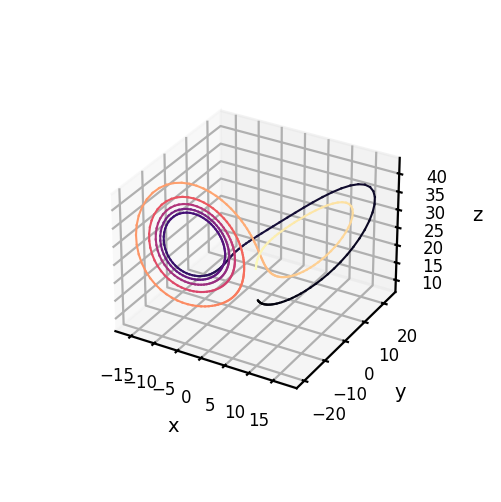

In [9]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200, subplot_kw ={'projection': '3d'})
# ax.plot(sim_data['x'], sim_data['y'], sim_data['z'], color='b', linewidth=1)

cvar = t_sim.copy()
cnorm = mpl.colors.Normalize(vmin=np.min(cvar), vmax=np.max(cvar))
cmap = mpl.colormaps['magma']

# Plot line segments with colors based on x values
for k in range(len(t_sim) - 1):
    ax.plot(sim_data['x'].values[k:k+2],
            sim_data['y'].values[k:k+2],
            sim_data['z'].values[k:k+2],
            color=cmap(cnorm(cvar[k])),
            linewidth=0.75,
            marker='.', markersize=0, markeredgecolor='none')
    
ax.set_xlabel('x', fontsize=7)
ax.set_ylabel('y', fontsize=7)
ax.set_zlabel('z', fontsize=7)

for a in [ax]:
    a.tick_params(axis='both', labelsize=6)
    
ax.set_box_aspect(None, zoom=0.7)

In [10]:
# plt.plot(sim_data['x'])
# plt.plot(sim_data['y'])
# plt.plot(sim_data['z'])

# Observability

In [11]:
# Construct observability matrix in sliding windows
w = 6  # window size
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4, parallel=False)

In [12]:
n_window = len(SEOM.O_df_sliding)
print(n_window, 'windows')

495 windows


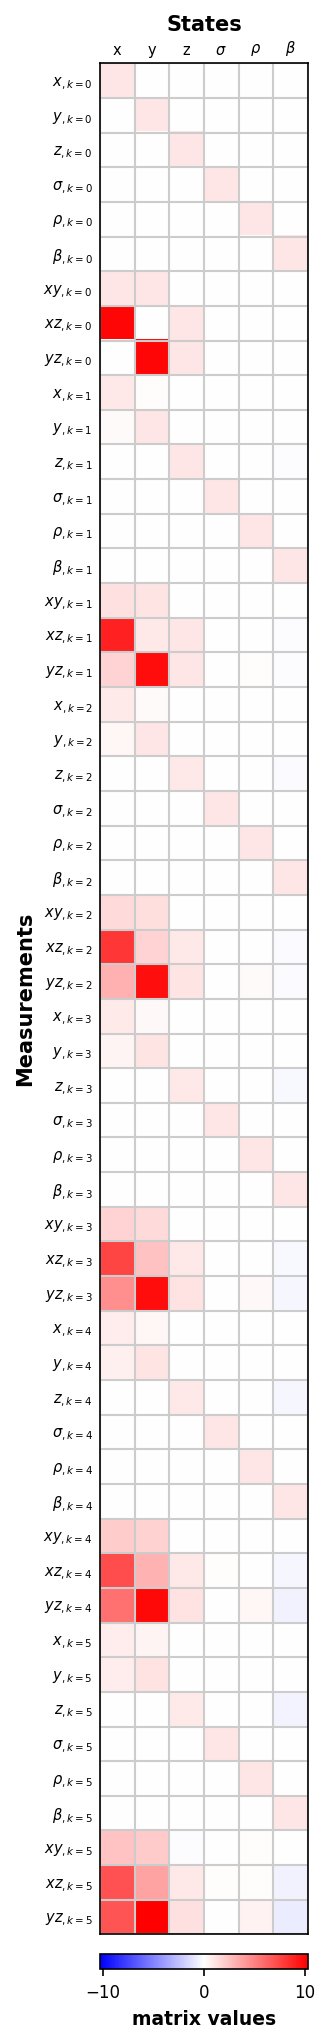

In [13]:
# Visualize observability matrix
OI = ObservabilityMatrixImage(SEOM.O_df_sliding[0], vmax_percentile=100, vmin_ratio=1.0, cmap='bwr')
OI.plot()

# Compute Fisher information matrix & inverse for each sliding window

In [14]:
# Choose sensors to use from O
# o_sensors = ['xy']
o_sensors = ['x', 'y', 'z']

# Chose states to use from O
# o_states = ['x', 'y', 'z']
o_states = ['x', 'y', 'z', 'sigma', 'rho', 'beta']


# Choose time-steps to use from O
window_size = 6
o_time_steps = np.arange(0, window_size, step=1)

In [15]:
# Set each sensor noise level separately
sensor_noise = {'x': 0.1, 'y': 0.1, 'z': 0.1, 'sigma': 0.1, 'rho': 0.1, 'beta':0.1, 'xy': 0.1, 'xz': 0.1, 'yz': 0.1}

In [16]:
# Compute Fisher information matrix & inverse for each sliding window
EV = []  # collect error variance data for each state over time
shift_index = int(np.round((1/2) * window_size))
shift_time = shift_index * dt  # shift the time forward by half the window size
for k in range(n_window):  # each window
    # Get full O
    O = SEOM.O_df_sliding[k]
    
    # Get subset of O
    O_subset = O.loc[(o_sensors, o_time_steps), o_states].sort_values(['time_step', 'sensor'])
    
    # Compute Fisher information & inverse
    FO = FisherObservability(O_subset, sensor_noise_dict=sensor_noise, sigma=1e-6)
    
    # Collect error variance data
    ev = FO.error_variance.copy()
    ev.insert(0, 'time_initial', SEOM.t_sim[k] + 0.0*shift_time)
    EV.append(ev)

# Concatenate error variance & make same size as simulation data
EV = pd.concat(EV, axis=0, ignore_index=True)
EV.index = np.arange(shift_index, EV.shape[0] + shift_index, step=1, dtype=int)
time_df = pd.DataFrame(np.atleast_2d(tsim).T, columns=['time'])
EV_aligned = pd.concat((time_df, EV), axis=1)

In [17]:
EV_aligned

,time,time_initial,x,y,z,sigma,rho,beta
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.03,0.00,0.041620,0.051921,0.054828,388.966317,56.531153,0.649740
4,0.04,0.01,0.045806,0.051390,0.054813,214.272465,52.148809,0.682987
...,...,...,...,...,...,...,...,...
495,4.95,4.92,0.064385,0.057688,0.054900,37.664115,35.921530,0.122284
496,4.96,4.93,0.064798,0.057390,0.054898,52.571075,43.738472,0.128975
497,4.97,4.94,0.065303,0.057038,0.054896,74.992966,52.482322,0.136022
498,4.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN


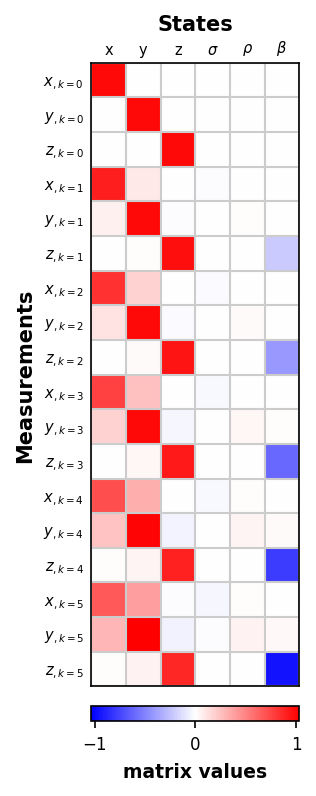

In [20]:
# Visualize observability matrix subset
OI = ObservabilityMatrixImage(O_subset, vmax_percentile=100, vmin_ratio=1.0, cmap='bwr')
OI.plot()

# Plot error variance as color on state time-series

In [18]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

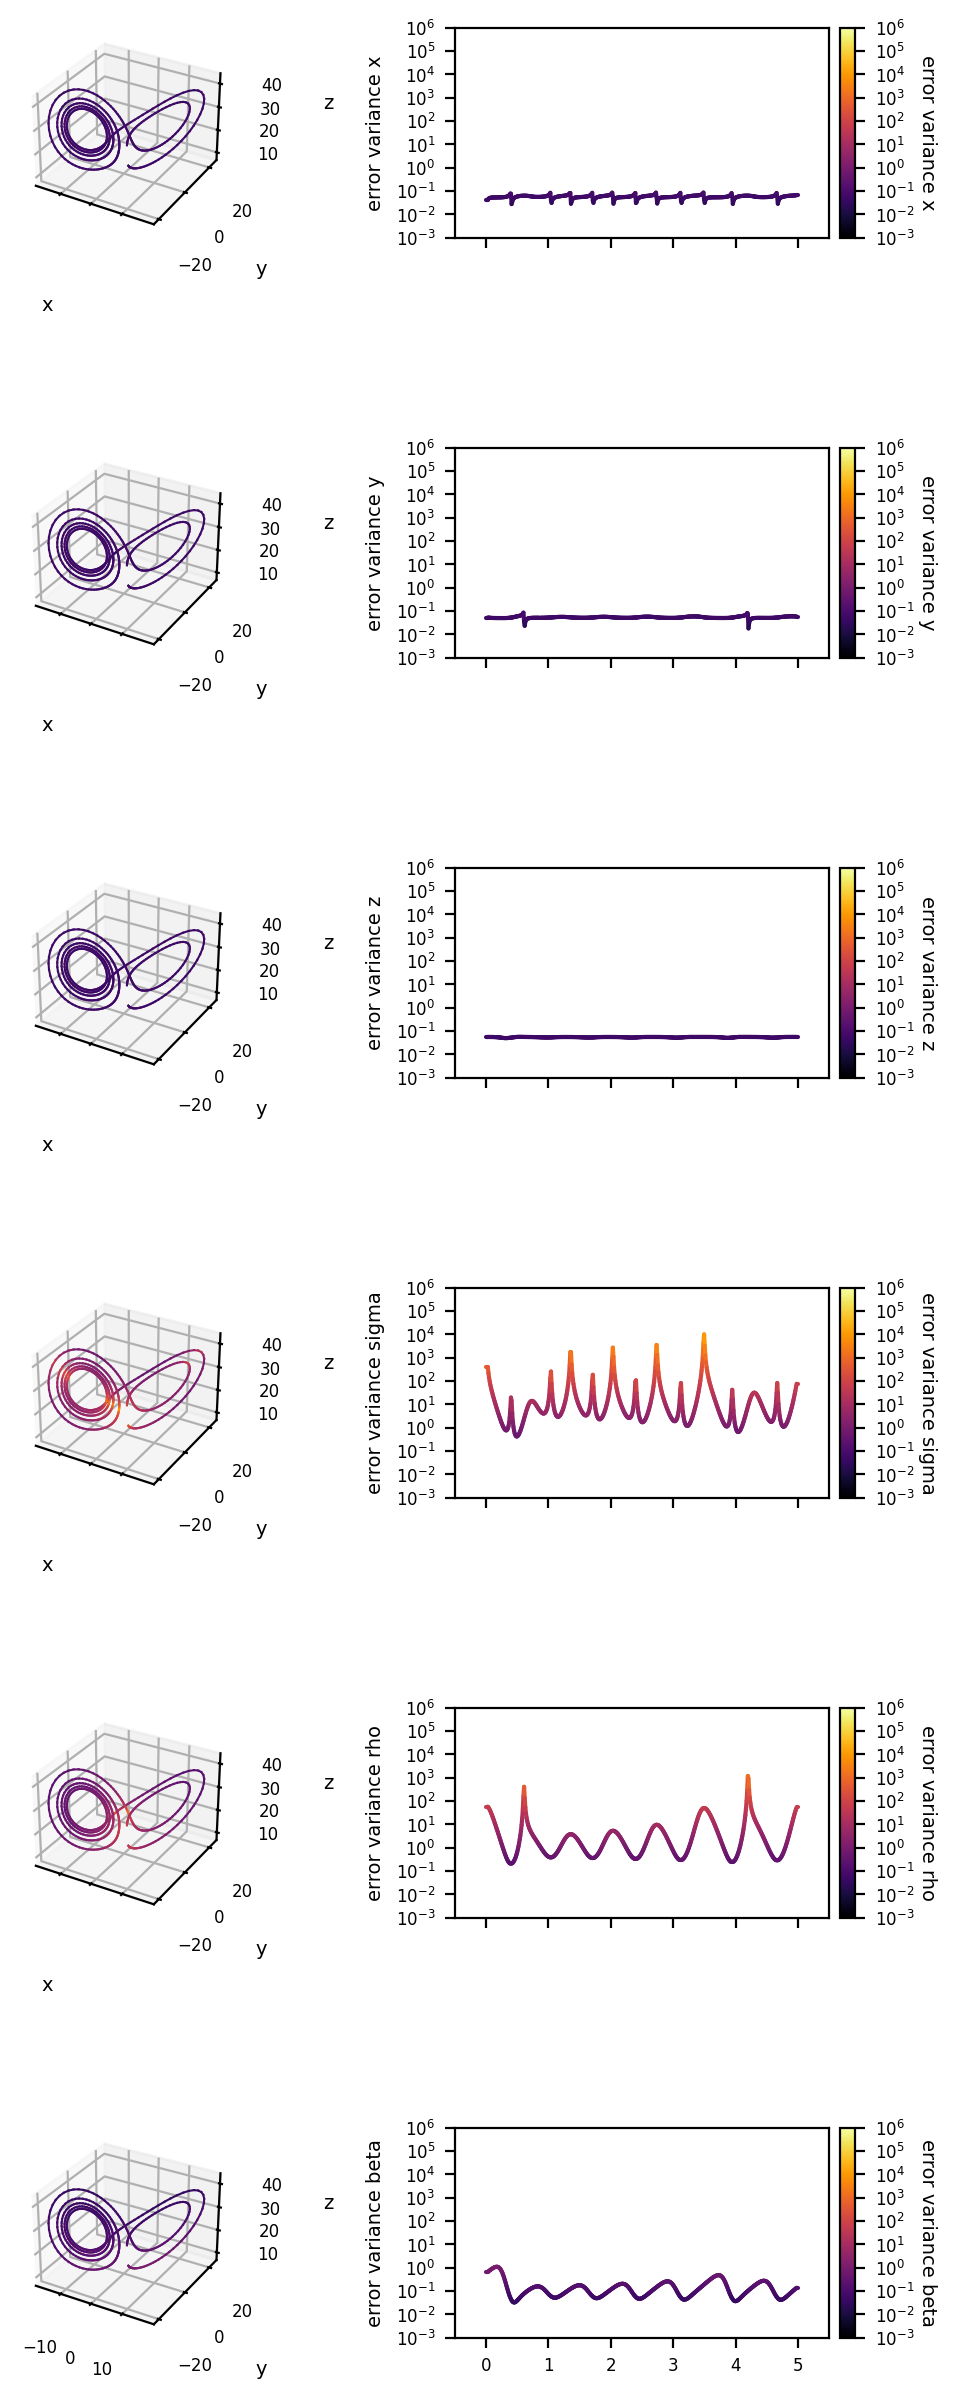

In [19]:
n_state = len(o_states)

cmap = mpl.colormaps['inferno']

log_tick_low = -3
log_tick_high = 6
ticks = np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1)
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

fig = plt.figure(figsize=(5, 2.5*n_state), dpi=200)
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1.0, 1.0], height_ratios=[1.0])

ax_traj = subfigs[0].subplots(nrows=n_state, ncols=1, sharex=True, sharey=True, subplot_kw ={'projection': '3d'}) 
ax_ev = subfigs[1].subplots(nrows=n_state, ncols=1, sharex=True, sharey=True)


for n, state_name in enumerate(o_states):
    cvar = EV_no_nan[state_name].values
    
    # Plot line segments with colors based on x values
    ax = ax_traj[n]
    for k in range(len(t_sim) - 1):
        ax.plot(sim_data['x'].values[k:k+2],
                sim_data['y'].values[k:k+2],
                sim_data['z'].values[k:k+2],
                color=cmap(cnorm(cvar[k])),
                linewidth=0.75,
                marker='.', markersize=0, markeredgecolor='none')
        
    ax.set_xlabel('x', fontsize=7)
    ax.set_ylabel('y', fontsize=7)
    ax.set_zlabel('z', fontsize=7)
    
    # Error variance
    colorline(sim_data['t'].values, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax_ev[n], cmap=cmap, norm=cnorm)
    
    ax_ev[n].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax_ev[n].set_yscale('log')
    ax_ev[n].set_ylabel('error variance ' + state_name, fontsize=7)
    ax_ev[n].set_yticks(ticks)
    ax_ev[n].set_xlim(t_sim[0] - 0.5, t_sim[-1] + 0.5)

    # Colorbar
    cax = ax_ev[n].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax, ticks=ticks)
    cbar.set_label('error variance ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

for a in list(ax_traj.flat) + list(ax_ev.flat):
    a.tick_params(axis='both', which='major', labelsize=6)
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.0, hspace=1.0)
